# Installs & Imports

In [1]:
!pip install -q neuralprophet plotly optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.8/145.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.6 MB/s eta 0:00:00


In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from datetime import datetime
from neuralprophet import NeuralProphet, set_log_level, set_random_seed
from sklearn.metrics import mean_squared_error, mean_absolute_error
import optuna
import seaborn as sns

# Suppress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Set plotting aesthetics
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

# Only log errors
set_log_level("ERROR")

ERROR:NP.plotly:Importing plotly failed. Interactive plots will not work.
ERROR:NP.plotly:Importing plotly failed. Interactive plots will not work.


# Load the Data

In [3]:
def load_data():
    """
    Load the Air Passengers dataset from seaborn library.

    Returns:
        pd.DataFrame: Loaded and initial dataframe.
    """
    df = sns.load_dataset('flights')
    return df

# Load the data
df = load_data()
df.head()

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


In [4]:
def preprocess_data(df):
    """
    Preprocess the dataframe by converting month to numerical format and renaming columns for NeuralProphet.

    Args:
        df (pd.DataFrame): Original dataframe.

    Returns:
        pd.DataFrame: Preprocessed dataframe with 'ds' and 'y' columns.
    """
    # Convert 'month' to numerical format
    df['month_num'] = pd.to_datetime(df['month'], format='%b').dt.month

    # Assign 'day' as 1
    df['day'] = 1

    # Drop original 'month' column to avoid duplicate keys
    df = df.drop(columns=['month'])

    # Rename 'month_num' to 'month' for pd.to_datetime compatibility
    df = df.rename(columns={'month_num': 'month'})

    # Create 'ds' datetime column using 'year', 'month', 'day'
    df['ds'] = pd.to_datetime(df[['year', 'month', 'day']])

    # Rename 'passengers' to 'y' for NeuralProphet
    df = df.rename(columns={'passengers': 'y'})

    # Sort by date
    df = df.sort_values('ds').reset_index(drop=True)

    # Keep only 'ds' and 'y' columns
    df = df[['ds', 'y']]

    return df

# Preprocess the data
df = preprocess_data(df)
df.head()

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


# Explore the Data

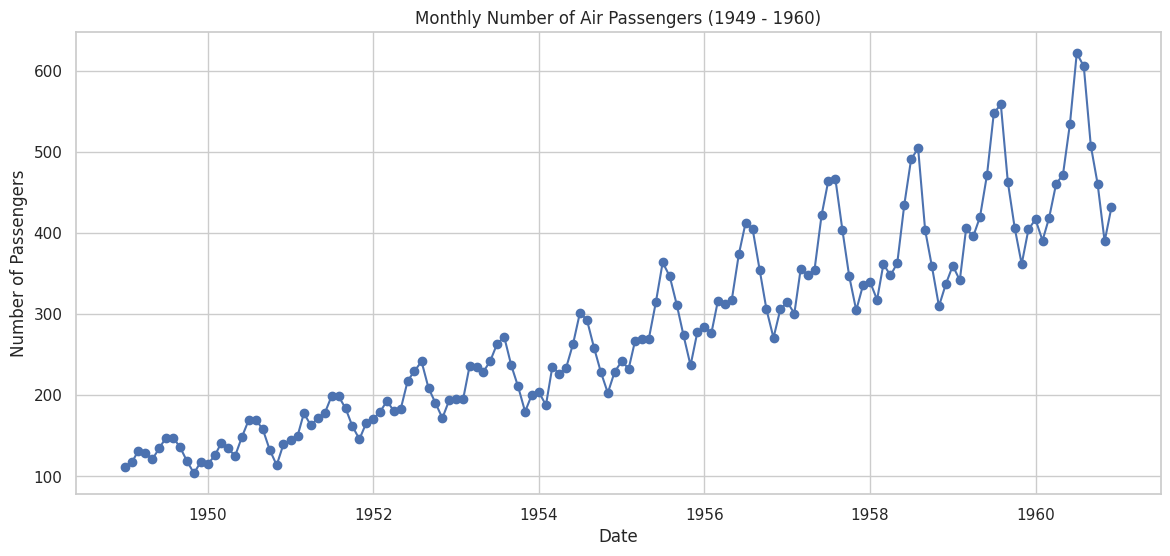

In [5]:
def plot_time_series(df):
    """
    Plot the time series data.

    Args:
        df (pd.DataFrame): Dataframe with 'ds' and 'y' columns.
    """
    plt.figure(figsize=(14,6))
    plt.plot(df['ds'], df['y'], marker='o', linestyle='-')
    plt.title('Monthly Number of Air Passengers (1949 - 1960)')
    plt.xlabel('Date')
    plt.ylabel('Number of Passengers')
    plt.grid(True)
    plt.show()

# Plot the time series
plot_time_series(df)

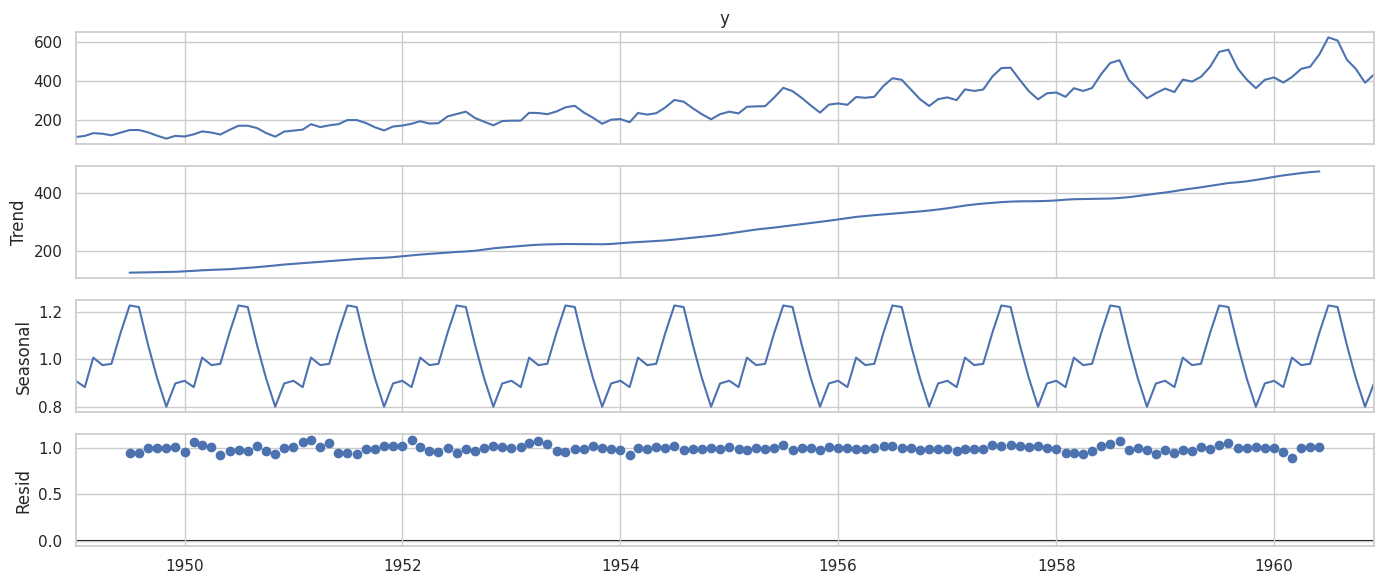

In [6]:
def decompose_time_series(df):
    """
    Decompose the time series into trend, seasonal, and residual components.

    Args:
        df (pd.DataFrame): Dataframe with 'ds' and 'y' columns.
    """
    from statsmodels.tsa.seasonal import seasonal_decompose

    # Set 'ds' as index
    df_decompose = df.set_index('ds')

    # Decompose the time series
    result = seasonal_decompose(df_decompose['y'], model='multiplicative')

    # Plot the decomposition
    result.plot()
    plt.show()

# Decompose the time series
decompose_time_series(df)

In [7]:
def check_stationarity(df):
    """
    Perform Augmented Dickey-Fuller test to check stationarity.

    Args:
        df (pd.DataFrame): Dataframe with 'y' column.

    Returns:
        dict: ADF test results.
    """
    from statsmodels.tsa.stattools import adfuller

    result = adfuller(df['y'])

    adf_results = {
        'ADF Statistic': result[0],
        'p-value': result[1],
        'Critical Values': result[4]
    }

    return adf_results

# Check for stationarity
adf_results = check_stationarity(df)
print('ADF Statistic: %f' % adf_results['ADF Statistic'])
print('p-value: %f' % adf_results['p-value'])
print('Critical Values:')
for key, value in adf_results['Critical Values'].items():
    print(f'\t{key}: {value}')

ADF Statistic: 0.815369
p-value: 0.991880
Critical Values:
	1%: -3.4816817173418295
	5%: -2.8840418343195267
	10%: -2.578770059171598


# Split the Data

In [8]:
def split_data(df, train_size=104, val_size=20):
    """
    Split the dataframe into training, validation, and test sets.

    Args:
        df (pd.DataFrame): Preprocessed dataframe with 'ds' and 'y' columns.
        train_size (int): Number of observations for training.
        val_size (int): Number of observations for validation.

    Returns:
        tuple: (df_train, df_val, df_test)
    """
    test_size = len(df) - train_size - val_size

    df_train = df.iloc[:train_size].reset_index(drop=True)
    df_val = df.iloc[train_size:train_size + val_size].reset_index(drop=True)
    df_test = df.iloc[train_size + val_size:].reset_index(drop=True)

    return df_train, df_val, df_test

# Split the data
df_train, df_val, df_test = split_data(df, train_size=104, val_size=20)

print("Training Set:")
print(df_train.head())
print("\nValidation Set:")
print(df_val.head())
print("\nTest Set:")
print(df_test.head())

Training Set:
          ds    y
0 1949-01-01  112
1 1949-02-01  118
2 1949-03-01  132
3 1949-04-01  129
4 1949-05-01  121

Validation Set:
          ds    y
0 1957-09-01  404
1 1957-10-01  347
2 1957-11-01  305
3 1957-12-01  336
4 1958-01-01  340

Test Set:
          ds    y
0 1959-05-01  420
1 1959-06-01  472
2 1959-07-01  548
3 1959-08-01  559
4 1959-09-01  463


In [9]:
# Print shapes
print("Training Set Shape:", df_train.shape)
print("Validation Set Shape:", df_val.shape)
print("Test Set Shape:", df_test.shape)

Training Set Shape: (104, 2)
Validation Set Shape: (20, 2)
Test Set Shape: (20, 2)


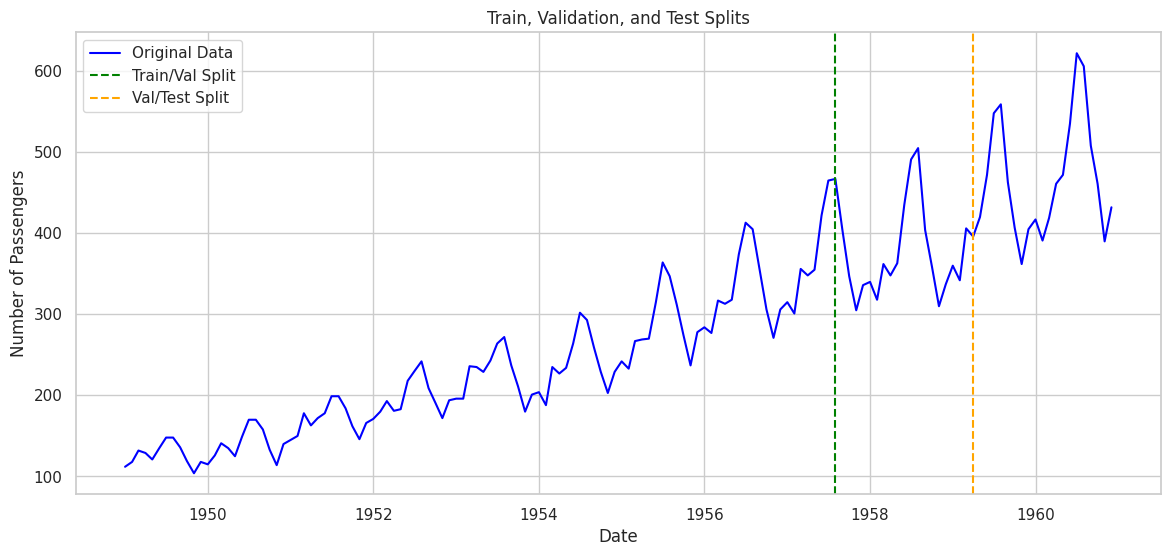

In [10]:
def visualize_splits(df, df_train, df_val, df_test):
    """
    Visualize the training, validation, and test splits on the time series plot.

    Args:
        df (pd.DataFrame): Original dataframe.
        df_train (pd.DataFrame): Training set.
        df_val (pd.DataFrame): Validation set.
        df_test (pd.DataFrame): Test set.
    """
    plt.figure(figsize=(14,6))
    plt.plot(df['ds'], df['y'], label='Original Data', color='blue')
    plt.axvline(df_train['ds'].iloc[-1], color='green', linestyle='--', label='Train/Val Split')
    plt.axvline(df_val['ds'].iloc[-1], color='orange', linestyle='--', label='Val/Test Split')
    plt.title('Train, Validation, and Test Splits')
    plt.xlabel('Date')
    plt.ylabel('Number of Passengers')
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualize the splits
visualize_splits(df, df_train, df_val, df_test)

# Prepare the Data

In [11]:
def check_missing_values(df_train, df_val, df_test):
    """
    Check for missing values in each dataset.

    Args:
        df_train (pd.DataFrame): Training set.
        df_val (pd.DataFrame): Validation set.
        df_test (pd.DataFrame): Test set.

    Returns:
        None
    """
    print("Missing values in Training Set:\n", df_train.isnull().sum())
    print("\nMissing values in Validation Set:\n", df_val.isnull().sum())
    print("\nMissing values in Test Set:\n", df_test.isnull().sum())

In [12]:
def preprocess(df_train, df_val, df_test):
    """
    Perform any additional preprocessing steps if necessary.

    Args:
        df_train (pd.DataFrame): Training set.
        df_val (pd.DataFrame): Validation set.
        df_test (pd.DataFrame): Test set.

    Returns:
        tuple: (df_train, df_val, df_test)
    """
    # Currently, no additional preprocessing is performed
    # Placeholder for future preprocessing steps
    return df_train, df_val, df_test

# Check for missing values
check_missing_values(df_train, df_val, df_test)

# Perform preprocessing
df_train, df_val, df_test = preprocess(df_train, df_val, df_test)

Missing values in Training Set:
 ds    0
y     0
dtype: int64

Missing values in Validation Set:
 ds    0
y     0
dtype: int64

Missing values in Test Set:
 ds    0
y     0
dtype: int64


# Tune the Models

In [13]:
def get_rmse(y_true, y_pred):
    """
    Compute Root Mean Squared Error (RMSE).

    Args:
        y_true (array-like): Actual values.
        y_pred (array-like): Predicted values.

    Returns:
        float: RMSE value.
    """
    return math.sqrt(mean_squared_error(y_true, y_pred))

def get_mae(y_true, y_pred):
    """
    Compute Mean Absolute Error (MAE).

    Args:
        y_true (array-like): Actual values.
        y_pred (array-like): Predicted values.

    Returns:
        float: MAE value.
    """
    return mean_absolute_error(y_true, y_pred)

def get_mape(y_true, y_pred):
    """
    Compute Mean Absolute Percentage Error (MAPE).

    Args:
        y_true (array-like): Actual values.
        y_pred (array-like): Predicted values.

    Returns:
        float: MAPE value in percentage.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

In [14]:
def train_and_predict_grid_search(df_train, H, params):
    """
    Train the NeuralProphet model and make predictions for Grid Search.

    Args:
        df_train (pd.DataFrame): Training dataframe with 'ds' and 'y' columns.
        H (int): Forecast horizon.
        params (dict): Dictionary containing hyperparameters.

    Returns:
        np.array: Predicted values for the forecast horizon.
    """
    # Initialize the NeuralProphet model with given hyperparameters
    m = NeuralProphet(
        n_changepoints=params['n_changepoints'],
        n_lags=params['n_lags'],
        yearly_seasonality=False,  # We'll add custom seasonality
        daily_seasonality=False,
        weekly_seasonality=False
    )

    # Add US holidays
    m.add_country_holidays(country_name='US')

    # Add monthly seasonality
    m.add_seasonality(name="monthly", period=30.5, fourier_order=params['fourier_order'])

    # Fit the model
    m.fit(df_train, freq='MS')

    # Create future dataframe
    future = m.make_future_dataframe(df_train, n_historic_predictions=True, periods=H)

    # Predict
    forecast = m.predict(future)

    # Extract the last H predictions
    preds = forecast['yhat1'].tail(H).values

    return preds

In [15]:
def grid_search_tuning(df_train, df_val, H, param_grid):
    """
    Perform Grid Search hyperparameter tuning.

    Args:
        df_train (pd.DataFrame): Training dataframe.
        df_val (pd.DataFrame): Validation dataframe.
        H (int): Forecast horizon.
        param_grid (dict): Dictionary containing lists of hyperparameters to try.

    Returns:
        pd.DataFrame: Results of the Grid Search.
    """
    # Initialize a list to store results
    results_list = []

    # Calculate total number of combinations
    total_combinations = len(param_grid['n_changepoints']) * len(param_grid['fourier_order']) * len(param_grid['n_lags'])
    current = 1

    # Loop over all combinations
    for n_cp in param_grid['n_changepoints']:
        for fo in param_grid['fourier_order']:
            for nl in param_grid['n_lags']:
                print(f"Evaluating Grid Search combination {current}/{total_combinations}: "
                      f"n_changepoints={n_cp}, fourier_order={fo}, n_lags={nl}")

                # Train and predict
                preds = train_and_predict_grid_search(df_train, H, {
                    'n_changepoints': n_cp,
                    'fourier_order': fo,
                    'n_lags': nl
                })

                # Evaluate predictions
                rmse = get_rmse(df_val['y'].values, preds)
                mae = get_mae(df_val['y'].values, preds)
                mape = get_mape(df_val['y'].values, preds)

                # Append results to the list
                results_list.append({
                    'n_changepoints': n_cp,
                    'fourier_order': fo,
                    'n_lags': nl,
                    'RMSE': rmse,
                    'MAE': mae,
                    'MAPE': mape
                })

                current += 1

    # Convert the list of results to a DataFrame
    results_df = pd.DataFrame(results_list)

    return results_df

In [16]:
# Define hyperparameter grid for Grid Search
param_grid = {
    'n_changepoints': [5, 10, 15],
    'fourier_order': [5, 10],
    'n_lags': [0, 5, 10]
}

# Define forecast horizon equal to validation set size
H_val = len(df_val)

# Perform Grid Search hyperparameter tuning
grid_search_results = grid_search_tuning(df_train, df_val, H_val, param_grid)

# Display the tuning results
print("Grid Search Tuning Results:")
display(grid_search_results.head())

Evaluating Grid Search combination 1/18: n_changepoints=5, fourier_order=5, n_lags=0


Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Evaluating Grid Search combination 2/18: n_changepoints=5, fourier_order=5, n_lags=5


Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Evaluating Grid Search combination 3/18: n_changepoints=5, fourier_order=5, n_lags=10


Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Evaluating Grid Search combination 4/18: n_changepoints=5, fourier_order=10, n_lags=0


Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Evaluating Grid Search combination 5/18: n_changepoints=5, fourier_order=10, n_lags=5


Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Evaluating Grid Search combination 6/18: n_changepoints=5, fourier_order=10, n_lags=10


Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Evaluating Grid Search combination 7/18: n_changepoints=10, fourier_order=5, n_lags=0


Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Evaluating Grid Search combination 8/18: n_changepoints=10, fourier_order=5, n_lags=5


Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Evaluating Grid Search combination 9/18: n_changepoints=10, fourier_order=5, n_lags=10


Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Evaluating Grid Search combination 10/18: n_changepoints=10, fourier_order=10, n_lags=0


Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Evaluating Grid Search combination 11/18: n_changepoints=10, fourier_order=10, n_lags=5


Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Evaluating Grid Search combination 12/18: n_changepoints=10, fourier_order=10, n_lags=10


Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Evaluating Grid Search combination 13/18: n_changepoints=15, fourier_order=5, n_lags=0


Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Evaluating Grid Search combination 14/18: n_changepoints=15, fourier_order=5, n_lags=5


Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Evaluating Grid Search combination 15/18: n_changepoints=15, fourier_order=5, n_lags=10


Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Evaluating Grid Search combination 16/18: n_changepoints=15, fourier_order=10, n_lags=0


Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Evaluating Grid Search combination 17/18: n_changepoints=15, fourier_order=10, n_lags=5


Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Evaluating Grid Search combination 18/18: n_changepoints=15, fourier_order=10, n_lags=10


Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Grid Search Tuning Results:


,n_changepoints,fourier_order,n_lags,RMSE,MAE,MAPE
0,5,5,0,75.615242,67.590721,18.972201
1,5,5,5,79.423515,56.743608,14.007960
2,5,5,10,88.158177,66.896907,16.749708
3,5,10,0,69.737989,59.827037,16.524743
4,5,10,5,79.786795,56.650209,13.966341


In [17]:
def train_and_predict_optuna(df_train, H, params):
    """
    Train the NeuralProphet model and make predictions for Optuna-based tuning.

    Args:
        df_train (pd.DataFrame): Training dataframe with 'ds' and 'y' columns.
        H (int): Forecast horizon.
        params (dict): Dictionary containing hyperparameters.

    Returns:
        np.array: Predicted values for the forecast horizon.
    """
    # Initialize the NeuralProphet model with given hyperparameters
    m = NeuralProphet(
        n_changepoints=params['n_changepoints'],
        n_lags=params['n_lags'],
        yearly_seasonality=False,  # We'll add custom seasonality
        daily_seasonality=False,
        weekly_seasonality=False
    )

    # Add US holidays
    m.add_country_holidays(country_name='US')

    # Add monthly seasonality
    m.add_seasonality(name="monthly", period=30.5, fourier_order=params['fourier_order'])

    # Fit the model
    m.fit(df_train, freq='MS')

    # Create future dataframe
    future = m.make_future_dataframe(df_train, n_historic_predictions=True, periods=H)

    # Predict
    forecast = m.predict(future)

    # Extract the last H predictions
    preds = forecast['yhat1'].tail(H).values

    return preds

In [18]:
def objective_optuna(trial, df_train, df_val):
    """
    Objective function for Optuna hyperparameter tuning.

    Args:
        trial (optuna.trial.Trial): Optuna trial object.
        df_train (pd.DataFrame): Training dataframe.
        df_val (pd.DataFrame): Validation dataframe.

    Returns:
        float: RMSE on the validation set.
    """
    # Suggest hyperparameters
    n_changepoints = trial.suggest_int('n_changepoints', 5, 20)
    fourier_order = trial.suggest_int('fourier_order', 5, 15)
    n_lags = trial.suggest_int('n_lags', 0, 15)

    # Define forecast horizon
    H = len(df_val)

    # Train and predict
    try:
        preds = train_and_predict_optuna(df_train, H, {
            'n_changepoints': n_changepoints,
            'fourier_order': fourier_order,
            'n_lags': n_lags
        })

        # Evaluate predictions
        rmse = get_rmse(df_val['y'].values, preds)

        return rmse
    except Exception as e:
        # In case of any error during training/prediction, return a large RMSE
        print(f"Error: {e}")
        return float('inf')

In [19]:
def hyperparameter_tuning_optuna(df_train, df_val, n_trials=20):
    """
    Perform hyperparameter tuning using Optuna.

    Args:
        df_train (pd.DataFrame): Training dataframe.
        df_val (pd.DataFrame): Validation dataframe.
        n_trials (int): Number of Optuna trials.

    Returns:
        optuna.trial.FrozenTrial: The best trial object.
        pd.DataFrame: DataFrame containing all trial results.
    """
    # Create a study object
    study = optuna.create_study(direction='minimize')

    # Optimize the objective function
    study.optimize(lambda trial: objective_optuna(trial, df_train, df_val), n_trials=n_trials)

    # Collect results
    results = []
    for trial in study.trials:
        results.append({
            'n_changepoints': trial.params['n_changepoints'],
            'fourier_order': trial.params['fourier_order'],
            'n_lags': trial.params['n_lags'],
            'RMSE': trial.value
        })

    results_df = pd.DataFrame(results)

    return study.best_trial, results_df

In [20]:
# Perform hyperparameter tuning with Optuna
best_trial_optuna, tuning_results_optuna = hyperparameter_tuning_optuna(df_train, df_val, n_trials=20)

# Display the tuning results
print("Optuna Hyperparameter Tuning Results:")
display(tuning_results_optuna.head())

# Display the best trial
print("\nOptuna Best Trial:")
print(f"Value (RMSE): {best_trial_optuna.value}")
print("Params:")
for key, value in best_trial_optuna.params.items():
    print(f"    {key}: {value}")

[I 2024-12-14 00:09:25,461] A new study created in memory with name: no-name-cd2eef48-f19c-48d5-9d20-b11ab845b2a2


Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-12-14 00:09:59,862] Trial 0 finished with value: 86.53004429417464 and parameters: {'n_changepoints': 8, 'fourier_order': 9, 'n_lags': 10}. Best is trial 0 with value: 86.53004429417464.


Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-12-14 00:10:35,982] Trial 1 finished with value: 84.06531530197199 and parameters: {'n_changepoints': 13, 'fourier_order': 12, 'n_lags': 7}. Best is trial 1 with value: 84.06531530197199.


Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-12-14 00:11:12,529] Trial 2 finished with value: 82.31263609870189 and parameters: {'n_changepoints': 16, 'fourier_order': 5, 'n_lags': 5}. Best is trial 2 with value: 82.31263609870189.


Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-12-14 00:11:48,960] Trial 3 finished with value: 83.7310794275846 and parameters: {'n_changepoints': 10, 'fourier_order': 7, 'n_lags': 5}. Best is trial 2 with value: 82.31263609870189.


Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-12-14 00:12:11,060] Trial 4 finished with value: 84.57579517484353 and parameters: {'n_changepoints': 19, 'fourier_order': 6, 'n_lags': 4}. Best is trial 2 with value: 82.31263609870189.


Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-12-14 00:12:31,119] Trial 5 finished with value: 78.31339023025009 and parameters: {'n_changepoints': 10, 'fourier_order': 5, 'n_lags': 0}. Best is trial 5 with value: 78.31339023025009.


Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-12-14 00:13:05,195] Trial 6 finished with value: 89.38133649150839 and parameters: {'n_changepoints': 18, 'fourier_order': 8, 'n_lags': 12}. Best is trial 5 with value: 78.31339023025009.


Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-12-14 00:13:26,928] Trial 7 finished with value: 76.84756389651885 and parameters: {'n_changepoints': 8, 'fourier_order': 10, 'n_lags': 1}. Best is trial 7 with value: 76.84756389651885.


Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-12-14 00:14:03,201] Trial 8 finished with value: 86.23149413401951 and parameters: {'n_changepoints': 5, 'fourier_order': 10, 'n_lags': 7}. Best is trial 7 with value: 76.84756389651885.


Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-12-14 00:14:38,014] Trial 9 finished with value: 87.8358626013986 and parameters: {'n_changepoints': 16, 'fourier_order': 10, 'n_lags': 10}. Best is trial 7 with value: 76.84756389651885.


Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-12-14 00:14:58,223] Trial 10 finished with value: 327.16224277538845 and parameters: {'n_changepoints': 5, 'fourier_order': 14, 'n_lags': 0}. Best is trial 7 with value: 76.84756389651885.


Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-12-14 00:15:18,072] Trial 11 finished with value: 246.71928837671976 and parameters: {'n_changepoints': 10, 'fourier_order': 15, 'n_lags': 0}. Best is trial 7 with value: 76.84756389651885.


Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-12-14 00:15:39,590] Trial 12 finished with value: 87.48185918455214 and parameters: {'n_changepoints': 8, 'fourier_order': 12, 'n_lags': 2}. Best is trial 7 with value: 76.84756389651885.


Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-12-14 00:16:00,932] Trial 13 finished with value: 80.33138733753636 and parameters: {'n_changepoints': 11, 'fourier_order': 12, 'n_lags': 2}. Best is trial 7 with value: 76.84756389651885.


Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-12-14 00:16:22,306] Trial 14 finished with value: 78.8108618057778 and parameters: {'n_changepoints': 13, 'fourier_order': 5, 'n_lags': 2}. Best is trial 7 with value: 76.84756389651885.


Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-12-14 00:16:57,333] Trial 15 finished with value: 90.19997112678129 and parameters: {'n_changepoints': 7, 'fourier_order': 7, 'n_lags': 14}. Best is trial 7 with value: 76.84756389651885.


Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-12-14 00:17:17,347] Trial 16 finished with value: 162.11697873337872 and parameters: {'n_changepoints': 11, 'fourier_order': 8, 'n_lags': 0}. Best is trial 7 with value: 76.84756389651885.


Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-12-14 00:17:40,035] Trial 17 finished with value: 84.72656078909469 and parameters: {'n_changepoints': 7, 'fourier_order': 11, 'n_lags': 3}. Best is trial 7 with value: 76.84756389651885.


Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-12-14 00:18:14,872] Trial 18 finished with value: 88.25568741615436 and parameters: {'n_changepoints': 15, 'fourier_order': 14, 'n_lags': 9}. Best is trial 7 with value: 76.84756389651885.


Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-12-14 00:18:51,822] Trial 19 finished with value: 83.84598960665602 and parameters: {'n_changepoints': 9, 'fourier_order': 9, 'n_lags': 5}. Best is trial 7 with value: 76.84756389651885.


Optuna Hyperparameter Tuning Results:


,n_changepoints,fourier_order,n_lags,RMSE
0,8,9,10,86.530044
1,13,12,7,84.065315
2,16,5,5,82.312636
3,10,7,5,83.731079
4,19,6,4,84.575795



Optuna Best Trial:
Value (RMSE): 76.84756389651885
Params:
    n_changepoints: 8
    fourier_order: 10
    n_lags: 1


# Train the Models

In [21]:
def train_final_model_grid_search(df_train_val, H, best_params):
    """
    Train the final NeuralProphet model using optimal Grid Search hyperparameters and make predictions.

    Args:
        df_train_val (pd.DataFrame): Combined training and validation dataframe.
        H (int): Forecast horizon (test set size).
        best_params (dict): Dictionary of optimal hyperparameters from Grid Search.

    Returns:
        tuple: (predictions, model, forecast)
    """
    # Initialize the NeuralProphet model with optimal hyperparameters
    m = NeuralProphet(
        n_changepoints=best_params['n_changepoints'],
        n_lags=best_params['n_lags'],
        yearly_seasonality=False,  # We'll add custom seasonality
        daily_seasonality=False,
        weekly_seasonality=False
    )

    # Add US holidays
    m.add_country_holidays(country_name='US')

    # Add monthly seasonality with optimal Fourier order
    m.add_seasonality(name="monthly", period=30.5, fourier_order=best_params['fourier_order'])

    # Fit the model
    m.fit(df_train_val, freq='MS')

    # Create future dataframe
    future = m.make_future_dataframe(df_train_val, n_historic_predictions=True, periods=H)

    # Predict
    forecast = m.predict(future)

    # Extract the last H predictions
    preds = forecast['yhat1'].tail(H).values

    return preds, m, forecast

In [22]:
# Combine training and validation sets
df_train_val = pd.concat([df_train, df_val], ignore_index=True)

# Define test set forecast horizon
H_test = len(df_test)

# Extract best hyperparameters from Grid Search
optimal_params_grid = {
    'n_changepoints': int(grid_search_results.loc[grid_search_results['RMSE'].idxmin()]['n_changepoints']),
    'fourier_order': int(grid_search_results.loc[grid_search_results['RMSE'].idxmin()]['fourier_order']),
    'n_lags': int(grid_search_results.loc[grid_search_results['RMSE'].idxmin()]['n_lags'])
}

# Train final Grid Search model and make predictions
predictions_grid, model_grid, forecast_grid = train_final_model_grid_search(df_train_val, H_test, optimal_params_grid)

# Display predictions
print("Grid Search Model Predictions on Test Set:")
print(predictions_grid)

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/208 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Grid Search Model Predictions on Test Set:
[391.60767 416.8842  393.22708 418.51828 414.84073 420.17117 416.47562
 421.8078  407.8569  404.9328  399.80823 425.04324 401.4314  426.69757
 403.05603 428.31534 424.68332 429.97018 426.29257 431.58588]


In [23]:
def train_final_model_optuna(df_train_val, H, best_trial):
    """
    Train the final NeuralProphet model using optimal Optuna hyperparameters and make predictions.

    Args:
        df_train_val (pd.DataFrame): Combined training and validation dataframe.
        H (int): Forecast horizon (test set size).
        best_trial (optuna.trial.FrozenTrial): Best trial object from Optuna.

    Returns:
        tuple: (predictions, model, forecast)
    """
    # Extract best hyperparameters from Optuna
    best_params = {
        'n_changepoints': best_trial.params['n_changepoints'],
        'fourier_order': best_trial.params['fourier_order'],
        'n_lags': best_trial.params['n_lags']
    }

    # Initialize the NeuralProphet model with optimal hyperparameters
    m = NeuralProphet(
        n_changepoints=best_params['n_changepoints'],
        n_lags=best_params['n_lags'],
        yearly_seasonality=False,  # We'll add custom seasonality
        daily_seasonality=False,
        weekly_seasonality=False
    )

    # Add US holidays
    m.add_country_holidays(country_name='US')

    # Add monthly seasonality with optimal Fourier order
    m.add_seasonality(name="monthly", period=30.5, fourier_order=best_params['fourier_order'])

    # Fit the model
    m.fit(df_train_val, freq='MS')

    # Create future dataframe
    future = m.make_future_dataframe(df_train_val, n_historic_predictions=True, periods=H)

    # Predict
    forecast = m.predict(future)

    # Extract the last H predictions
    preds = forecast['yhat1'].tail(H).values

    return preds, m, forecast

In [24]:
# Train final Optuna model and make predictions
predictions_optuna, model_optuna, forecast_optuna = train_final_model_optuna(df_train_val, H_test, best_trial_optuna)

# Display predictions
print("Optuna Model Predictions on Test Set:")
print(predictions_optuna)

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/208 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Optuna Model Predictions on Test Set:
[406.93042 331.24088 308.96237 328.22504 315.01013 361.27118 343.5279
 354.2356  344.5037  440.11783 470.93137 475.7843  417.9328  343.938
 312.42474 330.13257 337.47882 390.61234 388.1641  400.16336]


# Evaluate the Models

In [25]:
def evaluate_model_performance(df_test, predictions):
    """
    Evaluate the model's performance using RMSE, MAE, and MAPE.

    Args:
        df_test (pd.DataFrame): Test dataframe with 'ds' and 'y' columns.
        predictions (np.array): Predicted values.

    Returns:
        dict: Evaluation metrics.
    """
    actual = df_test['y'].values
    rmse = get_rmse(actual, predictions)
    mae = get_mae(actual, predictions)
    mape = get_mape(actual, predictions)

    metrics = {
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    }

    return metrics

In [26]:
# Evaluate Grid Search model performance
evaluation_metrics_grid = evaluate_model_performance(df_test, predictions_grid)
print("Grid Search Model Evaluation Metrics on Test Set:")
print(evaluation_metrics_grid)

# Evaluate Optuna model performance
evaluation_metrics_optuna = evaluate_model_performance(df_test, predictions_optuna)
print("\nOptuna Model Evaluation Metrics on Test Set:")
print(evaluation_metrics_optuna)

Grid Search Model Evaluation Metrics on Test Set:
{'RMSE': 89.6255977261109, 'MAE': 65.80769653320313, 'MAPE': 12.751627296793105}

Optuna Model Evaluation Metrics on Test Set:
{'RMSE': 143.9254278782816, 'MAE': 109.0039794921875, 'MAPE': 21.167935755570927}


In [27]:
def create_metrics_dataframe(metrics_grid, metrics_optuna):
    """
    Create a dataframe comparing evaluation metrics of Grid Search and Optuna models.

    Args:
        metrics_grid (dict): Evaluation metrics from Grid Search model.
        metrics_optuna (dict): Evaluation metrics from Optuna model.

    Returns:
        pd.DataFrame: Dataframe containing comparison metrics.
    """
    data = {
        'Metric': ['RMSE', 'MAE', 'MAPE'],
        'Grid Search': [metrics_grid['RMSE'], metrics_grid['MAE'], metrics_grid['MAPE']],
        'Optuna': [metrics_optuna['RMSE'], metrics_optuna['MAE'], metrics_optuna['MAPE']]
    }
    df_metrics = pd.DataFrame(data)
    return df_metrics

# Create metrics dataframe
df_metrics = create_metrics_dataframe(evaluation_metrics_grid, evaluation_metrics_optuna)
df_metrics

,Metric,Grid Search,Optuna
0,RMSE,89.625598,143.925428
1,MAE,65.807697,109.003979
2,MAPE,12.751627,21.167936


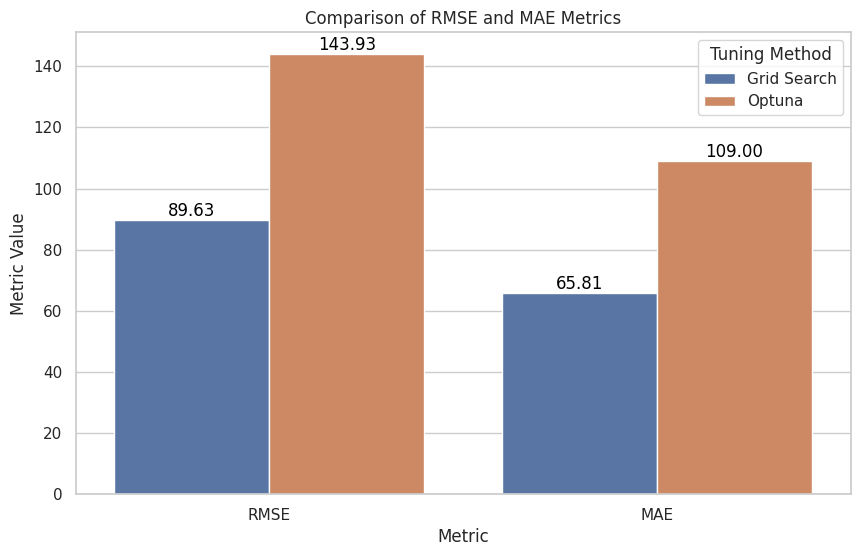

In [28]:
def plot_metrics_comparison(df_metrics):
    """
    Plot a grouped bar chart comparing RMSE and MAE metrics for both Grid Search and Optuna models.

    Args:
        df_metrics (pd.DataFrame): Dataframe containing comparison metrics.
    """
    # Melt the dataframe for easier plotting
    df_melt = df_metrics.melt(id_vars='Metric', var_name='Tuning Method', value_name='Value')

    # Filter for RMSE and MAE
    df_melt_filtered = df_melt[df_melt['Metric'].isin(['RMSE', 'MAE'])]

    # Create the bar plot
    plt.figure(figsize=(10,6))
    sns.barplot(x='Metric', y='Value', hue='Tuning Method', data=df_melt_filtered)

    # Add value labels above the bars
    for p in plt.gca().patches:
        height = p.get_height()
        if height > 0:
            plt.gca().annotate(f'{height:.2f}',
                            (p.get_x() + p.get_width() / 2., height),
                            ha='center', va='bottom', fontsize=12, color='black')

    plt.title('Comparison of RMSE and MAE Metrics')
    plt.ylabel('Metric Value')
    plt.xlabel('Metric')
    plt.legend(title='Tuning Method')
    plt.show()

# Plot metrics comparison
plot_metrics_comparison(df_metrics)

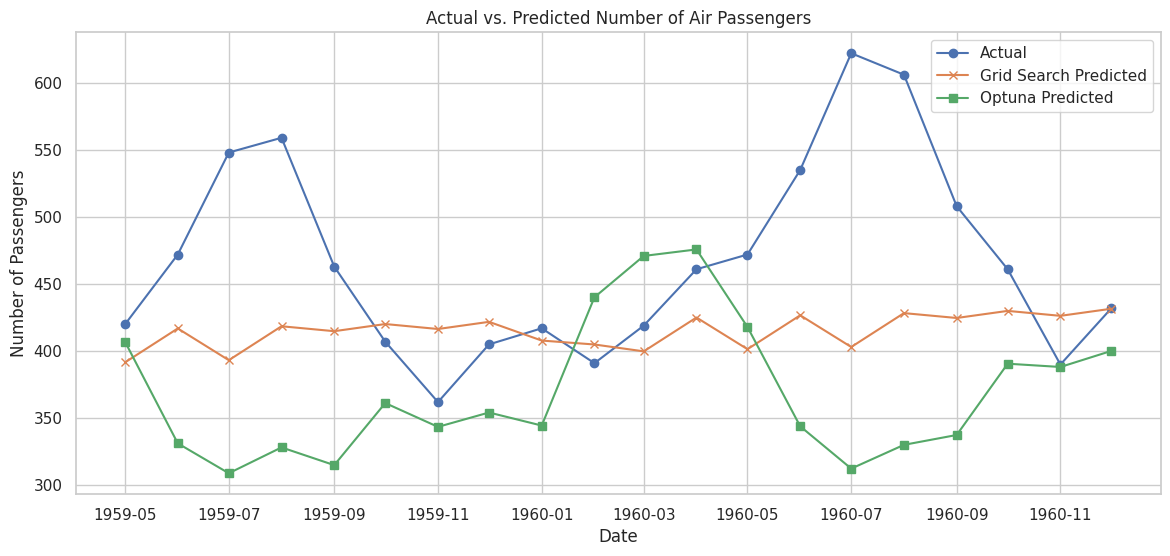

In [29]:
def plot_predictions_comparison(df_test, preds_grid, preds_optuna):
    """
    Plot actual vs. predicted values for both Grid Search and Optuna models.

    Args:
        df_test (pd.DataFrame): Test dataframe with 'ds' and 'y' columns.
        preds_grid (np.array): Predictions from Grid Search model.
        preds_optuna (np.array): Predictions from Optuna model.
    """
    # Create a dataframe for comparison
    df_compare = pd.DataFrame({
        'ds': df_test['ds'],
        'Actual': df_test['y'].values,
        'Grid Search Predicted': preds_grid,
        'Optuna Predicted': preds_optuna
    })

    # Plot actual vs. predicted
    plt.figure(figsize=(14,6))
    plt.plot(df_compare['ds'], df_compare['Actual'], label='Actual', marker='o')
    plt.plot(df_compare['ds'], df_compare['Grid Search Predicted'], label='Grid Search Predicted', marker='x')
    plt.plot(df_compare['ds'], df_compare['Optuna Predicted'], label='Optuna Predicted', marker='s')
    plt.title('Actual vs. Predicted Number of Air Passengers')
    plt.xlabel('Date')
    plt.ylabel('Number of Passengers')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot predictions comparison
plot_predictions_comparison(df_test, predictions_grid, predictions_optuna)

In [30]:
def compare_models(model1, forecast1, model1_name, model2, forecast2, model2_name):
    """
    Compare two NeuralProphet models by plotting their forecasts, components, and parameters.

    Args:
        model1 (NeuralProphet): The first trained NeuralProphet model.
        forecast1 (pd.DataFrame): The forecast dataframe for the first model.
        model1_name (str): Name identifier for the first model.
        model2 (NeuralProphet): The second trained NeuralProphet model.
        forecast2 (pd.DataFrame): The forecast dataframe for the second model.
        model2_name (str): Name identifier for the second model.
    """
    # 1. Plotting Forecasts
    print(f"\n--- Forecast Comparison: {model1_name} vs. {model2_name} ---\n")
    # Plot for Model 1
    model1.set_plotting_backend("plotly-static")
    print(f"Plotting Forecasts for {model1_name}...")
    model1.plot(forecast1)

    # Plot for Model 2
    model2.set_plotting_backend("plotly-static")
    print(f"Plotting Forecasts for {model2_name}...")
    model2.plot(forecast2)


    # 2. Plotting Components
    print(f"\n--- Components Comparison: {model1_name} vs. {model2_name} ---\n")
    # Components for Model 1
    print(f"Plotting Components for {model1_name}...")
    model1.plot_components(forecast1)

    # Components for Model 2
    print(f"Plotting Components for {model2_name}...")
    model2.plot_components(forecast2)


    # 3. Plotting Parameters
    print(f"\n--- Parameters Comparison: {model1_name} vs. {model2_name} ---\n")
    # Parameters for Model 1
    print(f"Plotting Parameters for {model1_name}...")
    model1.plot_parameters()

    # Parameters for Model 2
    print(f"Plotting Parameters for {model2_name}...")
    model2.plot_parameters()


--- Forecast Comparison: Grid Search Model vs. Optuna Model ---

Plotting Forecasts for Grid Search Model...


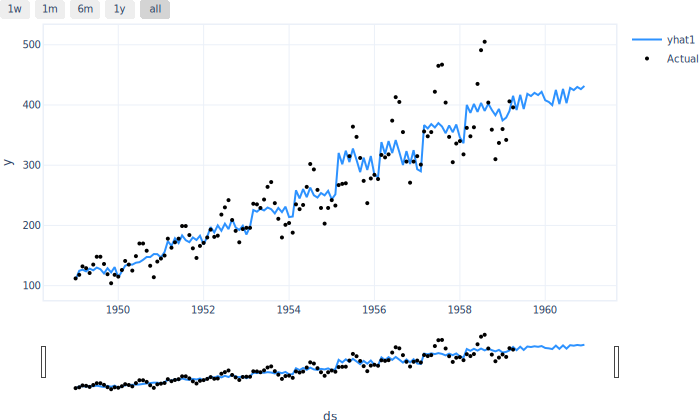

Plotting Forecasts for Optuna Model...


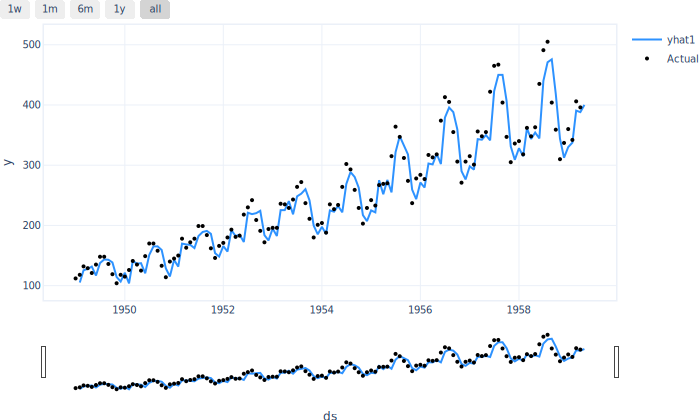


--- Components Comparison: Grid Search Model vs. Optuna Model ---

Plotting Components for Grid Search Model...


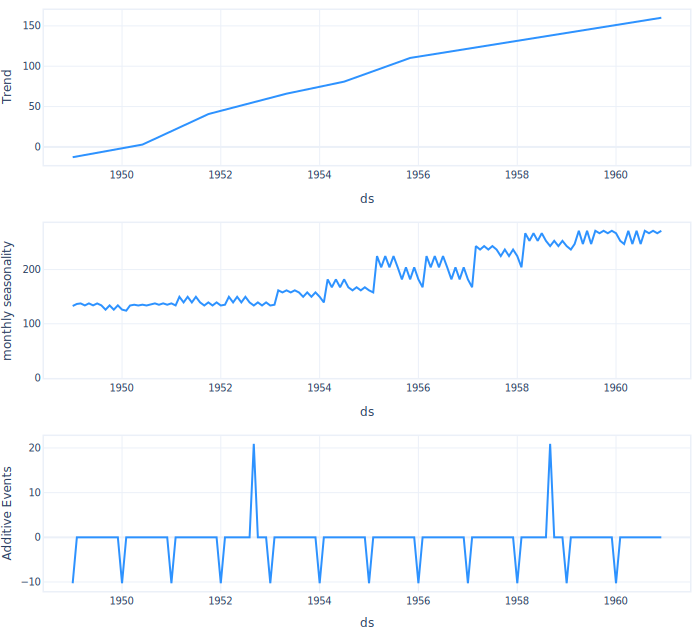

Plotting Components for Optuna Model...


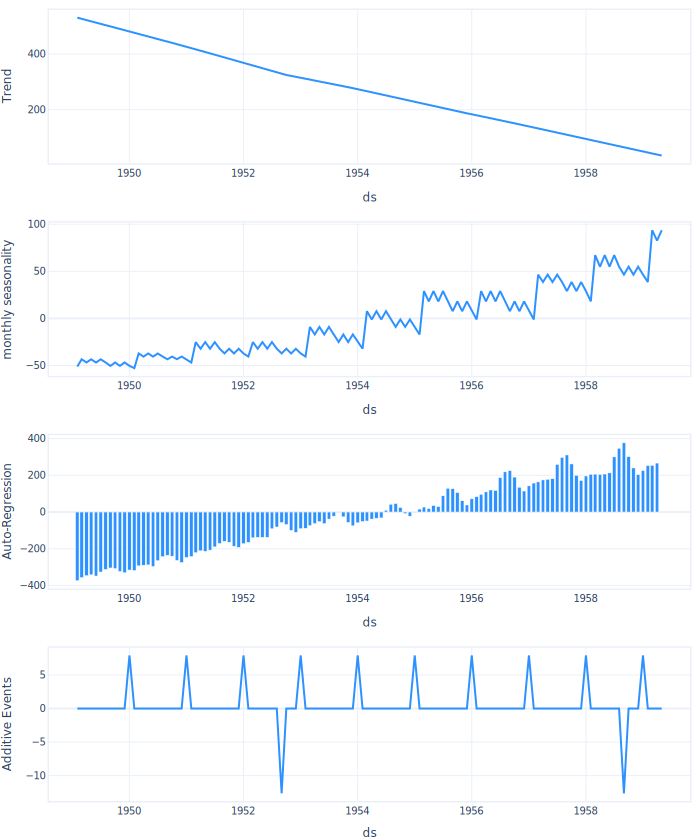


--- Parameters Comparison: Grid Search Model vs. Optuna Model ---

Plotting Parameters for Grid Search Model...


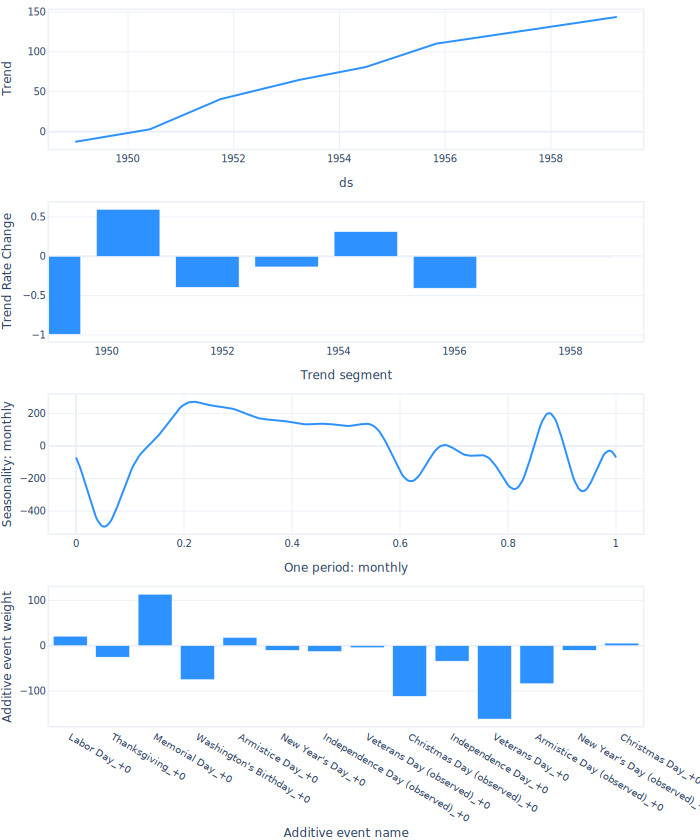

Plotting Parameters for Optuna Model...


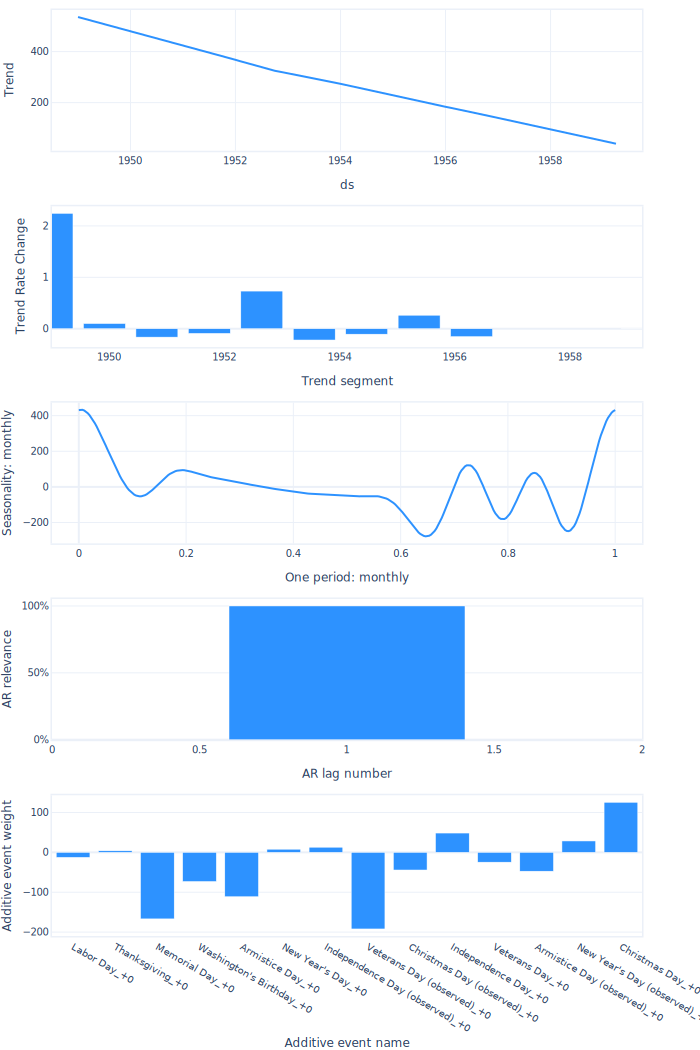

In [31]:
# Define model names
model1_name = "Grid Search Model"
model2_name = "Optuna Model"

# Call the comparison function
compare_models(
    model1=model_grid,
    forecast1=forecast_grid,
    model1_name=model1_name,
    model2=model_optuna,
    forecast2=forecast_optuna,
    model2_name=model2_name
)